In [22]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np
sys.path.append("/eos/home-g/gkrzmanc/jetclustering/code")
from src.dataset.dataset import SimpleIterDataset, EventDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)
from time import time

In [24]:

def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"]:
            continue
        out.append(item)
    return out

#path = "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"

def get_histogram(path, full_dataloader=True):
    if full_dataloader:
        datasets = os.listdir(path)
        datasets = [os.path.join(path, x) for x in datasets]
        datasets = datasets[:10]

        class Args:
            def __init__(self):
                self.data_train = datasets
                self.data_val = datasets
                #self.data_train = files_train
                self.data_config = '/eos/home-g/gkrzmanc/jetclustering/code/config_files/config_jets.yaml'
                self.extra_selection = None
                self.train_val_split = 0.8
                self.data_fraction = 1
                self.file_fraction = 1
                self.fetch_by_files = False
                self.fetch_step = 0.2
                self.steps_per_epoch = None
                self.in_memory = False
                self.local_rank = None
                self.copy_inputs = False
                self.no_remake_weights = False
                self.batch_size = 10
                self.num_workers = 0
                self.demo = False
                self.laplace = False
                self.diffs = False
                self.class_edges = False

        args = Args()
        train_range = (0, args.train_val_split)
        train_file_dict, train_files = to_filelist(args, 'train')
        train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                                       extra_selection=args.extra_selection,
                                       remake_weights=True,
                                       load_range_and_fraction=(train_range, args.data_fraction),
                                       file_fraction=args.file_fraction,
                                       fetch_by_files=args.fetch_by_files,
                                       fetch_step=args.fetch_step,
                                       infinity_mode=False,
                                       in_memory=args.in_memory,
                                       async_load=False,
                                       name='train', jets=True)

        iterator = iter(train_data)
    else:
        iterator = iter(EventDataset.from_directory(path))
    pt_jet = []
    pt_jet_all = []
    njets = []
    njets_gen = []
    jet_pt_gen = []
    jet_mass, jet_mass_filtered = [], []
    jet_area, jet_area_filtered = [], []
    n = 0
    while True:
        try:
            data = next(iterator)
            n += 1
            njgen = len(data.genjets)
            nj = len(data.jets)
            j_m = data.jets.mass.tolist()
            jet_mass += list(j_m)
            njets.append(nj)
            njets_gen.append(njgen)
            jet_pt = data.jets.pt.tolist()
            pt_jet_all += list(jet_pt)
            gen_jet_pt = data.genjets.pt.tolist()
            jet_pt_gen += list(gen_jet_pt)
            if nj < 2:
                continue
            jet_eta = data.jets.eta.tolist()
            max_idx = np.argmax(jet_pt)
            if jet_pt[max_idx] < 100 or abs(jet_eta[max_idx]) > 2.4:
                continue
            pt_jet.append(jet_pt[max_idx])
            jet_mass_filtered += list(j_m)
        except StopIteration:
            break
    #len(pt_jet), n
    return pt_jet, n, jet_mass, jet_area, njets, jet_mass_filtered, jet_area_filtered, pt_jet_all, jet_pt_gen, njets_gen

In [25]:
result = get_histogram("/eos/user/g/gkrzmanc/jetclustering/preprocessed_data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.3_alpha-peak", full_dataloader=False)

Constructing iterator took 1.1429381370544434 s
Filtering the event took 0.00014090538024902344 s
Filtering the event took 6.365776062011719e-05 s
Filtering the event took 4.57763671875e-05 s
Filtering the event took 4.100799560546875e-05 s
Filtering the event took 4.172325134277344e-05 s
Filtering the event took 4.076957702636719e-05 s
Filtering the event took 4.863739013671875e-05 s
Filtering the event took 4.0531158447265625e-05 s
Filtering the event took 4.0531158447265625e-05 s
Filtering the event took 4.887580871582031e-05 s
Filtering the event took 4.696846008300781e-05 s
Filtering the event took 3.910064697265625e-05 s
Filtering the event took 3.886222839355469e-05 s
Filtering the event took 0.0004165172576904297 s
Filtering the event took 5.7220458984375e-05 s
Filtering the event took 3.910064697265625e-05 s
Filtering the event took 4.38690185546875e-05 s
Filtering the event took 4.1484832763671875e-05 s
Filtering the event took 4.6253204345703125e-05 s
Filtering the event too

KeyboardInterrupt: 

1154


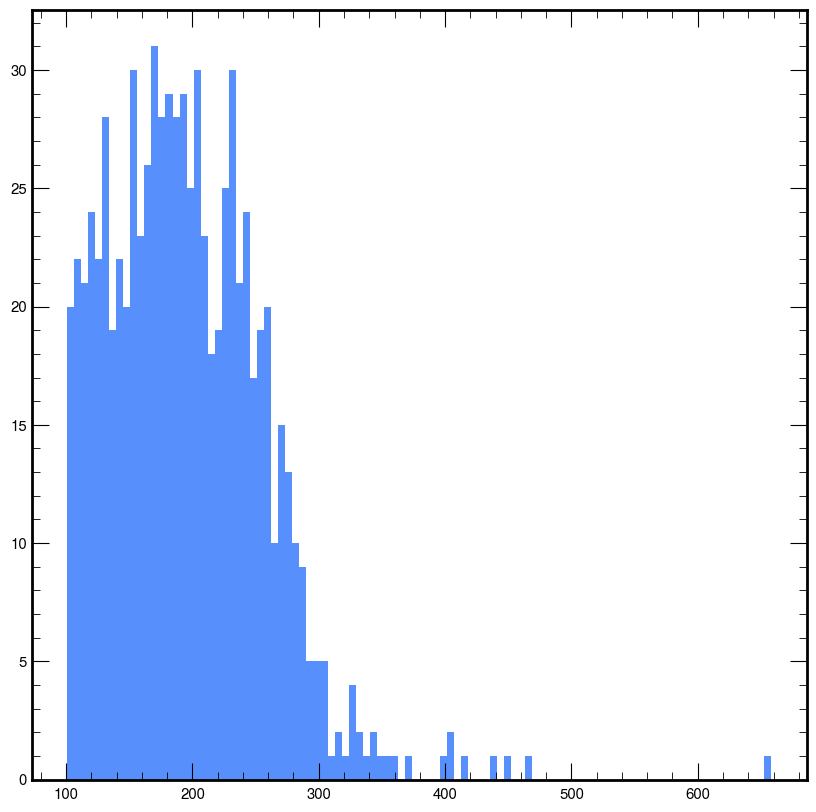

In [10]:
print(result[1])
fig, ax = plt.subplots()
ax.hist(result[0], bins=100)
fig.show()

In [17]:
paths = {
    0.3: "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.3_alpha-peak",
    0.5: "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.5_alpha-peak",
    0.7: "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"
}
paths = {
    0.3: "/eos/user/g/gkrzmanc/jetclustering/preprocessed_data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.3_alpha-peak",
    0.5: "/eos/user/g/gkrzmanc/jetclustering/preprocessed_data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.5_alpha-peak",
    0.7: "/eos/user/g/gkrzmanc/jetclustering/preprocessed_data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"
}


In [18]:
results = {}
for rinv in paths:
    print(rinv)
    results[rinv] = get_histogram(paths[rinv], full_dataloader=False)

0.3
0.5
0.7


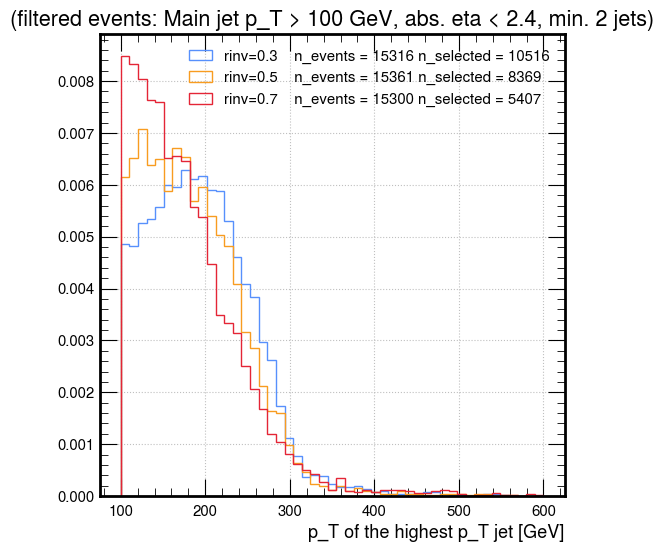

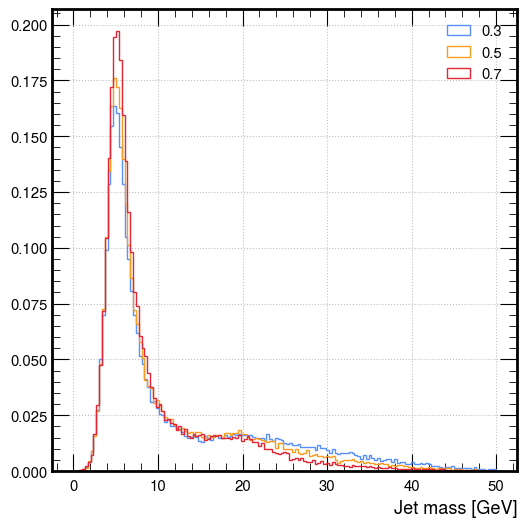

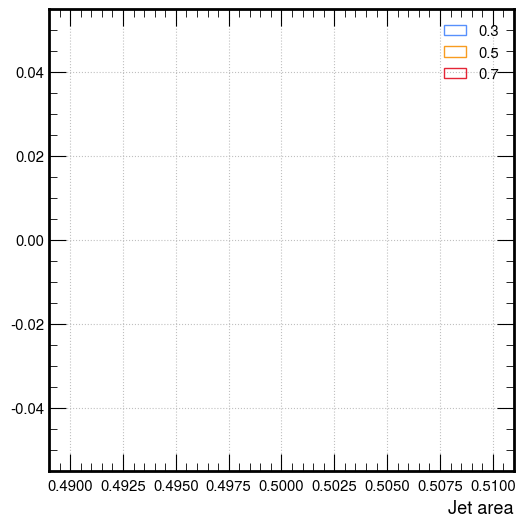

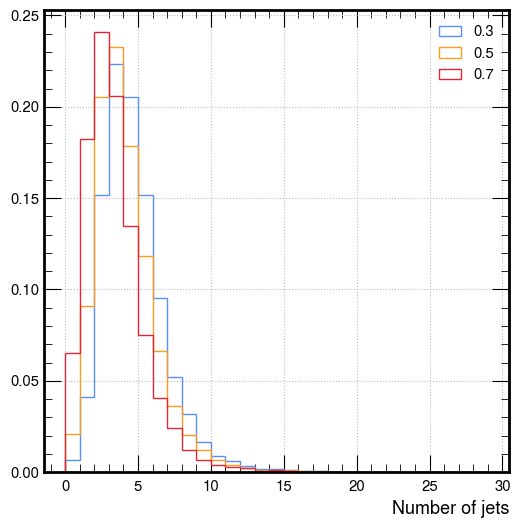

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
figmass, axmass = plt.subplots(figsize=(6, 6))
figarea, axarea = plt.subplots(figsize=(6, 6))
fig_nj, ax_nj = plt.subplots(figsize=(6, 6))

bins = np.linspace(100, 600, 50)
bins_mass = np.linspace(0, 50, 150)
bins_area = np.linspace(0.49, 0.51, 150)
bins_nj = list(range(30))

for key in results:
    result = results[key]
    ax.hist(result[0], bins=bins, label="rinv=" + str(key) + "    n_events = " + str(result[1]) + " n_selected = " + str(len(result[0])) , histtype="step", density=True)
    axmass.hist(result[2], bins=bins_mass, label=str(key), density=True, histtype="step")
    axarea.hist(result[3], bins=bins_area, label=str(key), density=True, histtype="step")
    ax_nj.hist(result[4], bins=bins_nj, label=str(key), density=True, histtype="step")
    #axmass.hist(result[4], bins=bins_mass, label=str(key) + " filtered", density=True, histtype="step")

ax.legend()
ax.grid()
ax.set_title('(filtered events: Main jet p_T > 100 GeV, abs. eta < 2.4, min. 2 jets)')
ax.set_xlabel("p_T of the highest p_T jet [GeV]")
axarea.set_xlabel("Jet area")

axarea.grid()
axmass.grid()
axmass.set_xlabel("Jet mass [GeV]")
axmass.legend()
axarea.legend()
ax_nj.legend()
ax_nj.grid()
ax_nj.set_xlabel("Number of jets")

fig.show()
figmass.show()
figarea.show()
fig_nj.show()

In [47]:
pt = results[0.3][7]
pt_gen=  results[0.3][8]

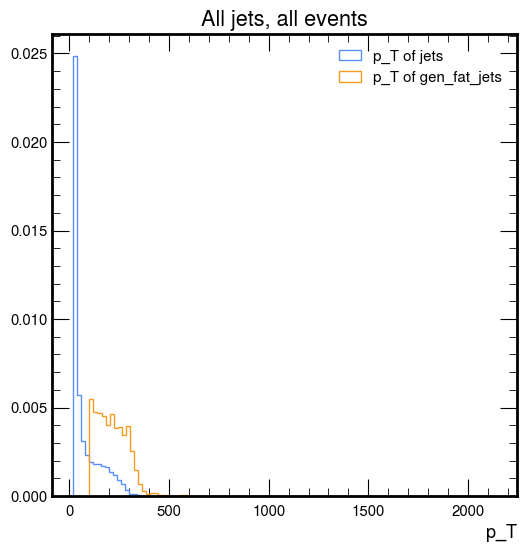

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(pt, bins=100, histtype="step", density=True, label="p_T of jets")
ax.hist(pt_gen, bins=100, histtype="step", density=True, label="p_T of gen_fat_jets")
ax.legend()
ax.set_title("All jets, all events")
ax.set_xlabel("p_T [GeV]")
fig.show()

In [49]:
pt_gen

[298.7321,
 146.2381,
 353.51157,
 138.05338,
 125.014114,
 155.11789,
 171.79688,
 106.159966,
 245.51248,
 172.1228,
 313.1776,
 311.74313,
 148.47278,
 138.68297,
 125.894356,
 256.95648,
 209.81462,
 104.65701,
 152.11983,
 159.63963,
 131.70422,
 271.63696,
 269.10425,
 218.83139,
 267.07086,
 252.81665,
 120.26063,
 119.41332,
 238.67326,
 112.48562,
 317.62662,
 125.81678,
 153.60768,
 270.62665,
 157.76213,
 303.78452,
 295.36273,
 280.92026,
 315.82834,
 288.61157,
 249.32812,
 195.47035,
 194.66376,
 368.70892,
 342.67456,
 109.85889,
 313.86627,
 142.76701,
 135.23166,
 189.22159,
 109.4953,
 184.87514,
 159.80974,
 188.1046,
 146.3511,
 169.92036,
 226.49144,
 236.36922,
 216.6938,
 190.60422,
 480.40027,
 299.27542,
 289.44418,
 127.6286,
 214.70285,
 206.04439,
 224.65068,
 354.3283,
 211.35078,
 235.2809,
 191.20026,
 126.54277,
 234.15636,
 181.25002,
 151.87856,
 277.61255,
 256.944,
 275.8415,
 275.4715,
 215.22485,
 287.77148,
 287.588,
 364.135,
 220.55925,
 177.152

In [29]:
njet_gen = results[0.3][9]

In [24]:
njet_gen

[3,
 2,
 4,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 3,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 3,
 0,
 2,
 2,
 1,
 1,
 2,
 0,
 3,
 1,
 2,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 2,
 3,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 3,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 3,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 2,
 3,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 3,
 0,
 2,
 3,
 1,
 2,
 2,
 3,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 4,
 0,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 3,
 1,
 2,
 3,
 3,
 0,
 2,
 2,
